# Import packages

In [1]:
#Sampling and GSA
from SALib.sample import saltelli
from SALib.analyze import sobol
import sobol_seq
import ghalton
from pyDOE import *
#Plot
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
#Deal with array and matrix
import numpy as np 
#Read csv
import csv
import pandas as pd
import xlsxwriter
#remove file
import os

# Definition

### Defintion for simulation sampling

In [2]:
#Defination
#Simulation
num = 3		#Number of variables. e.g. 3
num_samples_simulation = 500	 #Number of samples for simulation e.g. 100
method = 'sobol'		#Method for input simulation sampling,'sobol','halton' or 'latin'

skip = '' 		#For sobol method, default='', e.g. 3
seed = ''		#For halton method, default='', e.g. 3
latin_criterion = 'default'		#For latin_hypercube method, default='default'. Alternatives: 'center','maximin','centermaximin','correlation'

#Define variables
variablenames = ['rotor_core_stiffness','bearing_stiffness','foundation_stiffness']		
bounds = [[1e8,3e8],[4e8,8e8],[0.5e9,1.5e9]] 	 

#File name for fit surface result
Filename_simulation_sampling = 'ANSYS_Input.csv'

### Definition for run simulation  

In [3]:
#Names of output
names = ['P5','P6','P7','P8']


### Definition for cross validation

In [4]:
k_fold = 10 	#For k-fold cross-validation
#File name for fit surface result
Filename_fit_surface = 'output_GSA.csv'

### Definition for GSA samples

In [5]:
#saltelli
saltelli_second_order = False 
#Number of saltelli samples for GSA e.g. 500. When second_order is false,num_samples_saltelli/(num+2) should be integer, else num_samples_saltelli/(2*num+2) should be integer
num_samples_saltelli = 2000		
#Save saltelli samples
Save_saltelli_samples= True

File_result = 'result.xlsx'
sample_values={}
print('You have finnished the basic definition \nYou still need to continue with defining surrogate model and cross validation model later')

You have finnished the basic definition 
You still need to continue with defining surrogate model and cross validation model later


# Generate simulation samples

In [6]:
from scipy.stats import norm
bounds_mean= []
sigma=[]
for i in range(num):
    sigma.append((bounds[i][1]-bounds[i][0])/6)
#sampling
if method == 'sobol':
#Sobol
	if skip != '' :
		skip = int(skip)
		vec = sobol_seq.i4_sobol_generate(num,num_samples_simulation,skip)
		for i in range(num):
			sample_values[variablenames[i]]=list(vec[:,i])
	else:
		skip = 0
		vec = sobol_seq.i4_sobol_generate(num,num_samples_simulation)
		for i in range(num):
			sample_values[variablenames[i]]=list(vec[:,i])
	for i in range(num):
		bounds_mean.append((bounds[i][0]+bounds[i][1])/2)  
		sample_values[variablenames[i]]= norm.ppf(sample_values[variablenames[i]],loc=bounds_mean[i],scale=sigma[i])
	with open(Filename_simulation_sampling,'w',newline='') as f:
		writer = csv.writer(f)
		writer.writerow(['method',method,'num variables',num,'num samples',num_samples_simulation,'skip property',skip])
		writer.writerow(sample_values.keys())
		writer.writerows(zip(*sample_values.values()))

#Halton
elif method == 'halton':
	if seed != '' :	
		seed = int(seed)
		sequencer = ghalton.GeneralizedHalton(num,seed)
		points = sequencer.get(num_samples_simulation)
		for i in range(num):
			sample_values[variablenames[i]]=np.array(points)[:,i]
	else:
		sequencer = ghalton.GeneralizedHalton(num)
		points = sequencer.get(num_samples_simulation)
		for i in range(num):
			sample_values[variablenames[i]]=np.array(points)[:,i]
	for i in range(num):
		bounds_mean.append((bounds[i][0]+bounds[i][1])/2)  
		sample_values[variablenames[i]]= norm.ppf(sample_values[variablenames[i]],loc=bounds_mean[i],scale=sigma[i])
	with open(Filename_simulation_sampling,'w',newline='') as f:
		writer = csv.writer(f)
		writer.writerow(['method',method,'num variables',num,'num samples',num_samples_simulation,'seed',seed])
		writer.writerow(sample_values.keys())
		writer.writerows(zip(*sample_values.values()))

#Latin hypercube
elif method == 'latin':
	if latin_criterion == 'default':
		latin = lhs(num, samples=num_samples_simulation)
		for i in range(num):
			sample_values[variablenames[i]]=list(latin[:,i])
	else:
		latin = lhs(num, samples=num_samples_simulation,criterion=latin_criterion)
		for i in range(num):
			sample_values[variablenames[i]]=list(latin[:,i])
	for i in range(num):
		bounds_mean.append((bounds[i][0]+bounds[i][1])/2)  
		sample_values[variablenames[i]]= norm.ppf(sample_values[variablenames[i]],loc=bounds_mean[i],scale=sigma[i])
	with open(Filename_simulation_sampling,'w',newline='') as f:
		writer = csv.writer(f)
		writer.writerow(['method',method,'num variables',num,'num samples',num_samples_simulation,'criterion',latin_criterion])
		writer.writerow(sample_values.keys())
		writer.writerows(zip(*sample_values.values()))
else:
	print('Please type the correct method name !(sobol/halton/latin)')		

print('You have written simulation samples to '+str(Filename_simulation_sampling))

You have written simulation samples to ANSYS_Input.csv


# Run simulation

In [7]:
#Formula for run simulation
sample_values['P5'] = np.asarray(sample_values[variablenames[0]]) +np.asarray(sample_values[variablenames[1]]) +np.asarray(sample_values[variablenames[2]]) #simulation function
sample_values['P6'] = np.asarray(sample_values[variablenames[0]]**2) +np.asarray(sample_values[variablenames[1]]) +np.asarray(sample_values[variablenames[2]])
sample_values['P7'] = np.asarray(sample_values[variablenames[0]]**3) +np.asarray(sample_values[variablenames[1]]) +np.asarray(sample_values[variablenames[2]])
sample_values['P8'] = np.asarray(sample_values[variablenames[0]]**3) +np.asarray(sample_values[variablenames[1]]) +np.asarray(sample_values[variablenames[2]])


if method == 'sobol':
	with open(Filename_simulation_sampling,'w',newline='') as f:
		writer = csv.writer(f)
		writer.writerow(['method',method,'num variables',num,'num samples',num_samples_simulation,'skip property',skip])
		writer.writerow(sample_values.keys())
		writer.writerows(zip(*sample_values.values()))
elif method == 'halton':
	with open(Filename_simulation_sampling,'w',newline='') as f:
		writer = csv.writer(f)
		writer.writerow(['method',method,'num variables',num,'num samples',num_samples_simulation,'seed',seed])
		writer.writerow(sample_values.keys())
		writer.writerows(zip(*sample_values.values()))
elif method == 'latin':
	with open(Filename_simulation_sampling,'w',newline='') as f:
		writer = csv.writer(f)
		writer.writerow(['method',method,'num variables',num,'num samples',num_samples_simulation,'criterion',latin_criterion])
		writer.writerow(sample_values.keys())
		writer.writerows(zip(*sample_values.values()))
        
print('You have written simulation samples and run simulation reslut to '+str(Filename_simulation_sampling))

You have written simulation samples and run simulation reslut to ANSYS_Input.csv


# Fit_surface

### GSA sampling

In [6]:
problem={
'num_vars':num,'names':variablenames,'bounds':bounds
} 
if saltelli_second_order == False:
	param_values_GSA = saltelli.sample(problem,int(int(num_samples_saltelli)/(num+2)),calc_second_order=False)  
elif saltelli_second_order == True:
	param_values_GSA = saltelli.sample(problem,int(int(num_samples_saltelli)/(2*num+2)),calc_second_order=True) 
samples_GSA = {}
input_interpolation_data = pd.read_csv(Filename_simulation_sampling,header=1)
param_values=[[]for i in range(len(variablenames))]
input_interpolation_variables = [[]for i in range(len(variablenames)+1)]
for i in range(len(variablenames)):
	param_values[i]=param_values_GSA[:,i]
	input_interpolation_variables[i] = input_interpolation_data[variablenames[i]].iloc[:num_samples_simulation]

if Save_saltelli_samples == True:
	saltelli_samples={}
	for i in range(num):
		saltelli_samples[variablenames[i]]=list(param_values_GSA[:,i])
# get result seperately in csv file
	with open('Saltelli_samples.csv','w',newline='') as f:
		writer = csv.writer(f)
		writer.writerow(saltelli_samples.keys())
		writer.writerows(zip(*saltelli_samples.values()))

	print('You have generated GSA samples and save it to Saltelli_samples.csv')
else:
	print('You have generated GSA samples')

You have generated GSA samples and save it to Saltelli_samples.csv


## Load ANSYS result 

In [8]:
for i in range(len(variablenames)):
    sample_values[variablenames[i]]=input_interpolation_data[variablenames[i]].iloc[:num_samples_simulation]
                    

## Linear regression

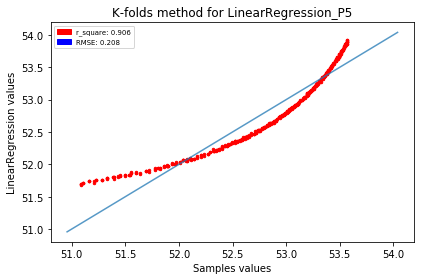

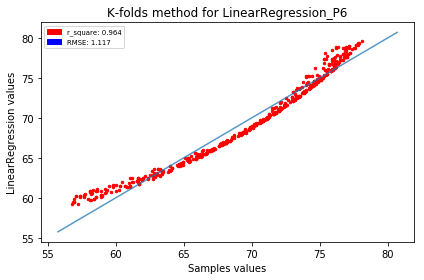

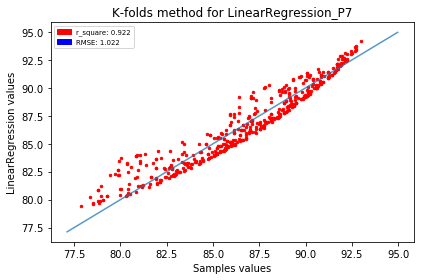

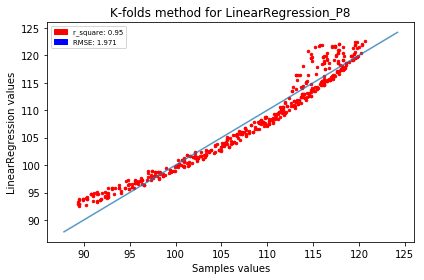

In [13]:
#Linear regression
samples_GSA_LP={}
from sklearn import linear_model

def linear_regression_k_fold(X,y,k_fold,num,names_result):
	GSA_linear_regression = linear_model.LinearRegression()
	linear_result=[]
	x_linear = [[]for i in range(num_samples_simulation)]
	for i in range(len(variablenames)):
		z = X[variablenames[i]]
		for j in range(num_samples_simulation):
			x_linear[j].append(z[j])
	subset_size = int(num_samples_simulation / k_fold)
	for k in range(k_fold):
		#Get X train data
		X_train = x_linear[:k * subset_size] +  x_linear[(k + 1) * subset_size:]
		X_train = np.array(X_train,dtype='float')

		y = np.array(y,dtype='float').tolist()
		y_train = y[:k * subset_size] + y[(k + 1) * subset_size:]     
        #Get train Linear Regression model
		train_linear = GSA_linear_regression.fit(X_train,y_train)

        #Get valid data
		X_valid =  x_linear[k * subset_size:][:subset_size]
		X_valid = np.array(X_valid,dtype='float')
        #Get valid result
		linear_valid_result = GSA_linear_regression.predict(X_valid).tolist()
		linear_result = linear_result+ linear_valid_result
	linear_result = np.array(linear_result,dtype='float')

	
	#Calculate RMSE
	rmse = round(np.sqrt(((linear_result-y)**2).mean()),3)
    #Calculate r square
	y_bar = np.sum(y)/len(y)  		#Calculate the mean of y
	SSR = np.sum((linear_result-y_bar)**2)   # or sum([ (yihat - ybar)**2 for yihat in yhat])
	sstot = np.sum((y-y_bar)**2)    # or sum([ (yi - ybar)**2 for yi in y])
	r_square = round(SSR / sstot,3)


	#Plot scatter graph
	plt.figure('k-fold method')
	plt.scatter(y,linear_result,c='r',cmap=plt.cm.coolwarm,zorder=2,s=6)
	plt.xlabel('Samples values')
	plt.ylabel('LinearRegression values')
	plt.title('K-folds method for LinearRegression_'+str(names_result))
	r_square_patch = mpatches.Patch(color='red',label='r_square: %s'%r_square)
	rmse_patch = mpatches.Patch(color='blue',label='RMSE: %s'%rmse )
	plt.legend(handles=[r_square_patch,rmse_patch],loc=0,fontsize = 'x-small')
	#Plot y=x 
	lims = [np.min([plt.gca().get_xlim(),plt.gca().get_ylim()]),np.max([plt.gca().get_xlim(),plt.gca().get_ylim()])] #plt.gca().get_ylim() get lim in y axis
	plt.plot(lims,lims,alpha=0.75)

	#Create text for r_square and RMSE
	plt.tight_layout()
	plt.show()
	plt.close()

y = [[]for i in range(len(names))]
for i in range(len(names)):
	y[i] = input_interpolation_data[names[i]].iloc[:num_samples_simulation]
	linear_regression_k_fold(sample_values,y[i],k_fold,num,names[i])

for i in range(len(names)):
	input_interpolation_variables[len(variablenames)] = y[i]
	x_linear = [[]for i in range(num_samples_simulation)]
	for k in range(len(variablenames)):
		z = input_interpolation_data[variablenames[k]].tolist()
		for j in range(num_samples_simulation):
			x_linear[j].append(z[j])
	model = linear_model.LinearRegression()
	model.fit(x_linear,y[i])
	samples_GSA_LP[names[i]] = model.predict(param_values_GSA)



## Support vector regression

## Find the best parameters

In [ ]:
#from sklearn.svm import SVR
#from sklearn.model_selection import GridSearchCV
#x_SVR = [[]for i in range(num_samples_simulation)]
#for i in range(len(variablenames)):
 #   z = sample_values[variablenames[i]]
  #  for j in range((num_samples_simulation)):
   #     x_SVR[j].append(z[j])
#svr = GridSearchCV(SVR(kernel='poly'), cv=5,param_grid={"C": [1e0,1e1],"degree": [1e0,5, 1e1],"gamma": [1,0.1,0.01]})
#svr.fit(x_SVR,np.array(y[0],dtype='float'))
#print("The best parameters are %s with a score of %0.2f"
 #     % (svr.best_params_, svr.best_score_))

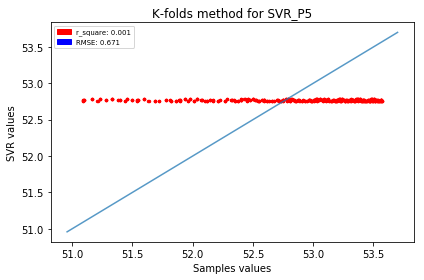

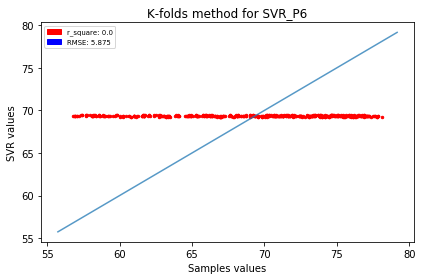

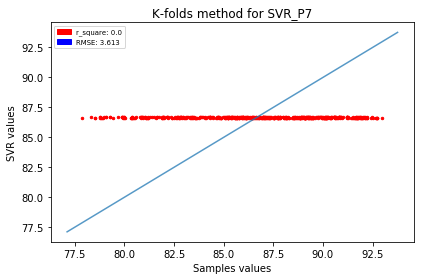

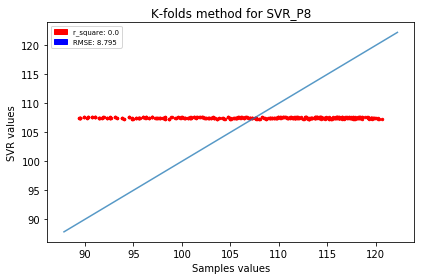

In [13]:
from sklearn import svm
samples_GSA_SVR={}
#SVR for k-fold cross validation
K_fold_SVR = svm.SVR(C=1000,  gamma=1,kernel='rbf') 
	#kernel = 'linear','rbf','poly','sigmoid,'precomputed'. default 'rbf'

def SVR_generator_k_fold(X,y,k_fold,num,names_result):
	SVR_result=[]
	#Convert nd.array to list (Once the array is created, th size can't be changed)
	x_SVR = [[]for i in range(num_samples_simulation)]
	for i in range(len(variablenames)):
		z = X[variablenames[i]]
		for j in range((num_samples_simulation)):
			x_SVR[j].append(z[j])
	subset_size = int(num_samples_simulation / k_fold)
		#Get X train data
	for k in range(k_fold):
		X_train = x_SVR[:k * subset_size] +  x_SVR[(k + 1) * subset_size:]
		X_train = np.array(X_train,dtype='float')

		#Get y train data
		y = np.array(y,dtype='float').tolist()
		y_train = y[:k * subset_size] + y[(k + 1) * subset_size:]     
		#Get train SVR model
		K_fold_SVR.fit(X_train,y_train)

		#Get valid data
		X_valid =  x_SVR[k * subset_size:][:subset_size]
		X_valid = np.array(X_valid,dtype='float')

		#Get valid result
		SVR_valid_result = K_fold_SVR.predict(X_valid).tolist()
		SVR_result = SVR_result+ SVR_valid_result


	SVR_result = np.array(SVR_result,dtype='float')
	#Calculate RMSE
	rmse = round(np.sqrt(((SVR_result-y)**2).mean()),3) 
	#Calculate r square
	y_bar = np.sum(y)/len(y)  		#Calculate the mean of y
	SSR = np.sum((SVR_result-y_bar)**2)   # or sum([ (yihat - ybar)**2 for yihat in yhat])
	sstot = np.sum((y-y_bar)**2)    # or sum([ (yi - ybar)**2 for yi in y])
	r_square = round(SSR / sstot,3)
    
	#Plot scatter graph
	plt.figure('k-fold method')
	plt.scatter(y,SVR_result,c='r',cmap=plt.cm.coolwarm,zorder=2,s=6)
	plt.xlabel('Samples values')
	plt.ylabel('SVR values')
	plt.title('K-folds method for SVR_'+str(names_result))
	r_square_patch = mpatches.Patch(color='red',label='r_square: %s'%r_square)
	rmse_patch = mpatches.Patch(color='blue',label='RMSE: %s'%rmse )
	plt.legend(handles=[r_square_patch,rmse_patch],loc=0,fontsize = 'x-small')
	#Plot y=x 
	lims = [np.min([plt.gca().get_xlim(),plt.gca().get_ylim()]),np.max([plt.gca().get_xlim(),plt.gca().get_ylim()])] #plt.gca().get_ylim() get lim in y axis
	plt.plot(lims,lims,alpha=0.75)

	#Create text for r_square and RMSE
	plt.tight_layout()
	plt.show()
	plt.close()

y = [[]for i in range(len(names))]
for i in range(len(names)):
	y[i] = input_interpolation_data[names[i]].iloc[:num_samples_simulation]
	SVR_generator_k_fold(sample_values,y[i],k_fold,num,names[i])

for i in range(len(names)):
	input_interpolation_variables[len(variablenames)] = y[i]
	x_SVR = [[]for i in range(num_samples_simulation)]
	for k in range(len(variablenames)):
		z = input_interpolation_data[variablenames[k]].tolist()
		for j in range(num_samples_simulation):
			x_SVR[j].append(z[j])
	K_fold_SVR.fit(x_SVR,y[i])
	samples_GSA_SVR[names[i]] = K_fold_SVR.predict(param_values_GSA.tolist())



In [ ]:
from sklearn.model_selection import GridSearchCV
x_SVR = [[]for i in range(num_samples_simulation)]
outputxxx=input_interpolation_data['P6'].iloc[:num_samples_simulation]
for i in range(len(variablenames)):
	z = sample_values[variablenames[i]]
	for j in range((num_samples_simulation)):
		x_SVR[j].append(z[j])
#svr = GridSearchCV(svm.SVR(kernel='rbf',epsilon=1e-6), cv=5,param_grid={"C": [1e0,1e3],"degree": [1e0,5, 1e1],"gamma": [1,0.1,0.01]})
a=svm.SVR(C=1000,  gamma=1,kernel='linear') 
a.fit(x_SVR,outputxxx)
SVR_result=a.predict(param_values_GSA.tolist())
#print(param_values_GSA)
#svr.fit(x_SVR,outputxxx)
#print("The best parameters are %s with a score of %0.2f"
    #  % (svr.best_params_, svr.best_score_))
print(min(SVR_result))
print(max(SVR_result))
print(SVR_result)

In [82]:
print(type(outputxxx))

<class 'pandas.core.series.Series'>


## Gaussian process regression

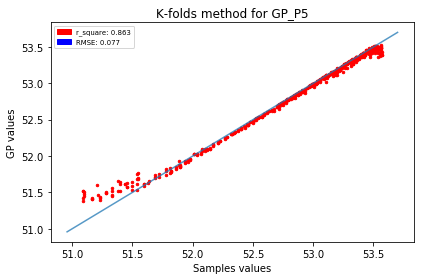

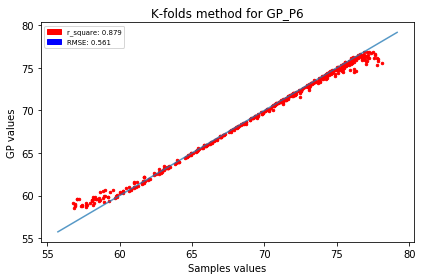

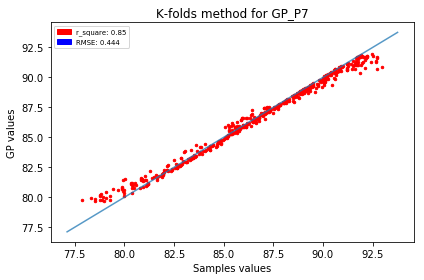

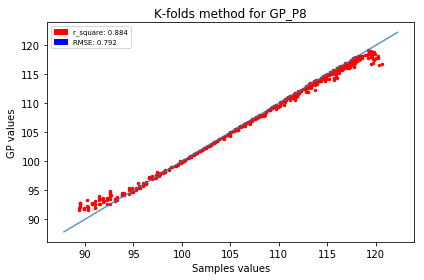

In [49]:
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel,RationalQuadratic
kernel = RationalQuadratic(length_scale=1.0, alpha=1.0)
samples_GSA_GPR={}
#kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GPR(kernel=kernel, alpha = 0, n_restarts_optimizer=9)

def Gaussian_process_generator_k_fold(X,y,k_fold,num,names_result):
	GP_result=[]
	#Convert nd.array to list (Once the array is created, th size can't be changed)
	x_GP = [[]for i in range(num_samples_simulation)]
	for i in range(len(variablenames)):
		z = X[variablenames[i]]
		for j in range((num_samples_simulation)):
			x_GP[j].append(z[j])
	subset_size = int(num_samples_simulation / k_fold)
	for k in range(k_fold):
		#Get X train data
		X_train = x_GP[:k * subset_size] +  x_GP[(k + 1) * subset_size:]
		X_train = np.array(X_train,dtype='float')

		#Get y train data
		y = np.array(y,dtype='float').tolist()
		y_train = y[:k * subset_size] + y[(k + 1) * subset_size:]     

		#Get train GP model
		train_GP = gp.fit(X_train,y_train)

		#Get valid data
		X_valid =  x_GP[k * subset_size:][:subset_size]
		X_valid = np.array(X_valid,dtype='float')

		#Get valid result
		GP_valid_result = gp.predict(X_valid).tolist()
		GP_result = GP_result+ GP_valid_result
    
	GP_result = np.array(GP_result,dtype='float')
    
	#Calculate RMSE
	rmse = round(np.sqrt(((GP_result-y)**2).mean()),3)
	#Calculate r square
	y_bar = np.sum(y)/len(y)  		#Calculate the mean of y
	SSR = np.sum((GP_result-y_bar)**2)   # or sum([ (yihat - ybar)**2 for yihat in yhat])
	sstot = np.sum((y-y_bar)**2)    # or sum([ (yi - ybar)**2 for yi in y])
	r_square = round(SSR / sstot,3)
	
	#Plot scatter graph
	plt.figure('k-fold method')
	plt.scatter(y,GP_result,c='r',cmap=plt.cm.coolwarm,zorder=2,s=6)
	plt.xlabel('Samples values')
	plt.ylabel('GP values')
	plt.title('K-folds method for GP_'+str(names_result))
	r_square_patch = mpatches.Patch(color='red',label='r_square: %s'%r_square)
	rmse_patch = mpatches.Patch(color='blue',label='RMSE: %s'%rmse )
	plt.legend(handles=[r_square_patch,rmse_patch],loc=0,fontsize = 'x-small')
	#Plot y=x 
	lims = [np.min([plt.gca().get_xlim(),plt.gca().get_ylim()]),np.max([plt.gca().get_xlim(),plt.gca().get_ylim()])] #plt.gca().get_ylim() get lim in y axis
	plt.plot(lims,lims,alpha=0.75)

	#Create text for r_square and RMSE
	plt.tight_layout()
	plt.show()
	plt.close()
 
y = [[]for i in range(len(names))]
for i in range(len(names)):
	y[i] = input_interpolation_data[names[i]].iloc[:num_samples_simulation]
	Gaussian_process_generator_k_fold(sample_values,y[i],k_fold,num,names[i])

for i in range(len(names)):
	input_interpolation_variables[len(variablenames)] = y[i]
	x_GP = [[]for i in range(num_samples_simulation)]
	for k in range(len(variablenames)):
		z = input_interpolation_data[variablenames[k]].tolist()
		for j in range(num_samples_simulation):
			x_GP[j].append(z[j])
	gp.fit(x_GP,y[i])
	samples_GSA_GPR[names[i]] = gp.predict(param_values_GSA.tolist(),return_std=None)



## Scipy rbf

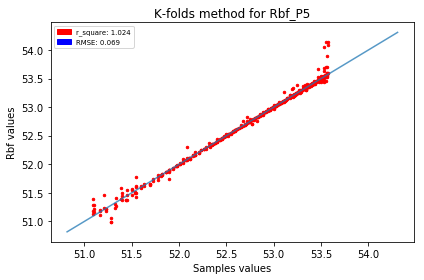

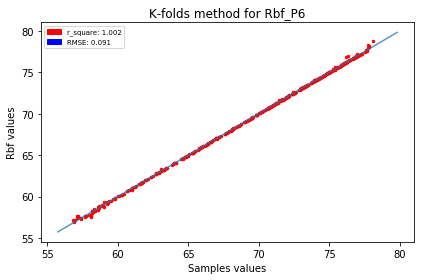

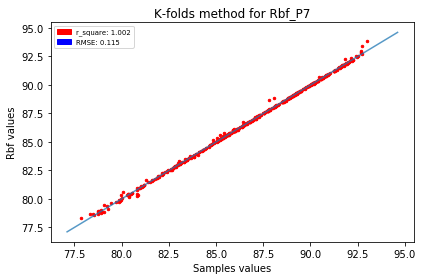

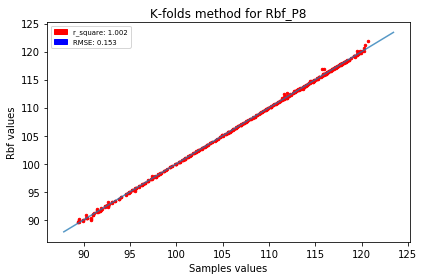

In [35]:
from scipy.interpolate import Rbf
samples_GSA_RBF={}

rbf_function = 'thin_plate' #Alternatives: 'multiquadric'(default),'inverse','gaussian','linear','cubic','quintic','thin_plate'

def k_fold_generator(X, y, k_fold,num,names_result):
    rbf_result=[]
    #Convert nd.array to list (Once the array is created, th size can't be changed)
    x_rbf = [[]for i in range(num_samples_simulation)]
    for i in range(len(variablenames)):
    	z = X[variablenames[i]]
    	for j in range((num_samples_simulation)):
    		x_rbf[j].append(z[j])
    subset_size = int(num_samples_simulation / k_fold)
    for k in range(k_fold):
        rbf_train = [[] for i in range(num+1)]
        #Get X train data
        X_train = x_rbf[:k * subset_size] +  x_rbf[(k + 1) * subset_size:]
        X_train = np.array(X_train,dtype='float')
        
        for i in range(num):
        	rbf_train[i] = X_train[:,i].tolist()
        #Get y train data
        y = np.array(y,dtype='float').tolist()
        y_train = y[:k * subset_size] + y[(k + 1) * subset_size:]     
        rbf_train[num] = y_train
        #Get train Rbf model
        train_rbf = Rbf(*rbf_train,function=rbf_function)

        #Get valid data
        rbf_valid = [[] for i in range(num)]
        X_valid =  x_rbf[k * subset_size:][:subset_size]
        X_valid = np.array(X_valid,dtype='float')
        for i in range(num):
        	rbf_valid[i] = X_valid[:,i].tolist()  
        #Get valid result
        rbf_valid_result = train_rbf(*rbf_valid).tolist()
        rbf_result = rbf_result+ rbf_valid_result
    
    rbf_result = np.array(rbf_result,dtype='float')

    #Calculate RMSE
    rmse = round(np.sqrt(((rbf_result-y)**2).mean()),3)
    #Calculate r square
    y_bar = np.sum(y)/len(y)  		#Calculate the mean of y
    SSR = np.sum((rbf_result-y_bar)**2)   # or sum([ (yihat - ybar)**2 for yihat in yhat])
    sstot = np.sum((y-y_bar)**2)    # or sum([ (yi - ybar)**2 for yi in y])
    r_square = round(SSR / sstot,3)

    #Plot scatter graph
    plt.figure('k-fold method')
    plt.scatter(y,rbf_result,c='r',cmap=plt.cm.coolwarm,zorder=2,s=6)
    plt.xlabel('Samples values')
    plt.ylabel('Rbf values')
    plt.title('K-folds method for Rbf_'+str(names_result))
    r_square_patch = mpatches.Patch(color='red',label='r_square: %s'%r_square)
    rmse_patch = mpatches.Patch(color='blue',label='RMSE: %s'%rmse )
    plt.legend(handles=[r_square_patch,rmse_patch],loc=0,fontsize = 'x-small')
    #Plot y=x 
    lims = [np.min([plt.gca().get_xlim(),plt.gca().get_ylim()]),np.max([plt.gca().get_xlim(),plt.gca().get_ylim()])] #plt.gca().get_ylim() get lim in y axis
    plt.plot(lims,lims,alpha=0.75)

    #Create text for r_square and RMSE
    plt.tight_layout()
    plt.show()
    plt.close()


y = [[]for i in range(len(names))]
for i in range(len(names)):
	y[i] = input_interpolation_data[names[i]].iloc[:num_samples_simulation]
	k_fold_generator(sample_values,y[i],k_fold,num,names[i])

for i in range(len(names)):
	input_interpolation_variables[len(variablenames)] = y[i]
	rbf_GSA_function = Rbf(*input_interpolation_variables)
	samples_GSA_RBF[names[i]] =  rbf_GSA_function(*param_values)



# GSA

### Choose which surrogate model you want to use for generate GSA input

In [12]:
GSA_Surrogate_model= 'SVR' #'LP','SVR','GPR',LP=Linear regression, SVR= Support vector regression, GPR= Gaussian process regression
if GSA_Surrogate_model == 'LP':
    samples_GSA= samples_GSA_LP
elif GSA_Surrogate_model == 'SVR':
    samples_GSA= samples_GSA_SVR
elif GSA_Surrogate_model == 'GPR':
    samples_GSA= samples_GSA_GPR
else:
	print('You have to choose the right model')


with open (Filename_fit_surface,'w',newline='') as f:
	writer = csv.writer(f)
	writer.writerow(samples_GSA.keys())
	writer.writerows(zip(*samples_GSA.values()))
    
print('You have saved Surrogate model predict result')

You have saved Surrogate model predict result


In [19]:
# Sensitivity analysis

def GSA(names=names,saltelli_samples=num_samples_saltelli ):
	#Total data for all names
	#Read data
	input_GSA_input_data = pd.read_csv(Filename_fit_surface,header=0)
	#Store names data in seperate list
	input_GSA_names = [[] for i in range(len(names))]
	for i in range(len(names)):
		input_GSA_names[i] = input_GSA_input_data[names[i]].iloc[:num_samples_saltelli]
		input_GSA_names[i] = np.array(input_GSA_names[i],dtype='float')
# # #Sensitivity analysis

	GSA_conf_S1 = [[]for i in range(len(names))]
	GSA_conf_ST = [[]for i in range(len(names))]
	GSA_result_S1 = [[]for i in range(len(names))]
	GSA_result_ST = [[]for i in range(len(names))]

	sobol_analyze_result = [[]for i in range(len(names))]
# 	#sobol_anlyze
	for i in range(len(names)):
		if saltelli_second_order == False:
			sobol_analyze_result[i] = sobol.analyze(problem,input_GSA_names[i],calc_second_order=False)
		elif saltelli_second_order == True:
			sobol_analyze_result[i] = sobol.analyze(problem,input_GSA_names[i],calc_second_order=True)
		#Get sensitivity analysis result,S1,ST,conf_S1,conf_ST
		GSA_result_S1[i] = sobol_analyze_result[i]['S1']
		GSA_result_ST[i] = sobol_analyze_result[i]['ST']
		GSA_conf_S1[i] = sobol_analyze_result[i]['S1_conf']
		GSA_conf_ST[i] = sobol_analyze_result[i]['ST_conf']


#Plot

	for i in range(len(names)):
		width=0.2
		plt.bar(np.arange(num),GSA_result_S1[i],width,yerr=GSA_conf_S1[i],capsize=7,align='center',alpha=0.5,color='red')
		plt.bar(np.arange(num)+0.3,GSA_result_ST[i],width,yerr=GSA_conf_ST[i],capsize=7,align='center',alpha=0.5,color='blue')
		plt.xticks(np.arange(num),variablenames)
		plt.xlabel('Variables')
		plt.ylabel('Sensitivity_values')
		plt.title('Sensitivity_analysis_'+names[i])
		S1_patch = mpatches.Patch(color='red',label='S1') #create legend
		ST_patch = mpatches.Patch(color='blue',label='ST')
		plt.legend(handles=[S1_patch,ST_patch],loc=1,fontsize = 'x-small')
		plt.tight_layout()
		# graph name = names[i]
		plt.savefig(names[i])
		plt.close()

#xlsx
#Write worksheet
	workbook = xlsxwriter.Workbook(File_result)
	for i in range(len(names)):	
		worksheet_title = workbook.add_worksheet(names[i])
		worksheet_title.write('A1',names[i])
		worksheet_title.write('A2','Variables')
		worksheet_title.write('B2','S1')
		worksheet_title.write('C2','Conf_S1')
		worksheet_title.write('D2','S1_Conf')
		worksheet_title.write('E2','ST')
		worksheet_title.write('F2','Conf_ST')
		worksheet_title.write('G2','ST_Conf')
		worksheet_title.set_column(0,0,25)
		worksheet_title.set_column(3,3,15)
		worksheet_title.set_column(6,6,15)
		#Write result(values) in the grid 
		for row in range(len(variablenames)) :
			worksheet_title.write('A'+str(row+3),variablenames[row])
			worksheet_title.write('B'+str(row+3),sobol_analyze_result[i]['S1'][row])
			worksheet_title.write('C'+str(row+3),sobol_analyze_result[i]['S1_conf'][row])
			worksheet_title.write_string('D'+str(row+3),str([round(sobol_analyze_result[i]['S1'][row]-sobol_analyze_result[i]['S1_conf'][row],3),round(sobol_analyze_result[i]['S1'][row]+sobol_analyze_result[i]['S1_conf'][row],3)]))
			worksheet_title.write('E'+str(row+3),sobol_analyze_result[i]['ST'][row])
			worksheet_title.write('F'+str(row+3),sobol_analyze_result[i]['ST_conf'][row])
			worksheet_title.write_string('G'+str(row+3),str([round(sobol_analyze_result[i]['ST'][row]-sobol_analyze_result[i]['ST_conf'][row],3),round(sobol_analyze_result[i]['ST'][row]+sobol_analyze_result[i]['ST_conf'][row],3)]))
			worksheet_title.insert_image('B'+str(6+len(variablenames)),names[i]+'.png',{'x_scale':1,'y_scale':1})
			#insert image
	#close the workbook
	workbook.close()
			#remove the graph from folder
	for i in range(len(names)):
		os.remove(names[i]+'.png')

GSA = GSA()
print('You have finished GSA')

You have finished GSA
